In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns

import cv2
import os

from sklearn import linear_model, preprocessing, pipeline
from sklearn.tree import DecisionTreeRegressor

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVEFOLDER = 'save_folder_here'

sns.set_theme()
torch.manual_seed(42)

In [2]:
project_folders = ['plots', 'pinn_results', 'regular_nn_results', 'pinn_disc_results', 'regular_vs_pinn']

for folder in project_folders:
    os.makedirs(os.path.join(SAVEFOLDER, folder), exist_ok=True)

# NN functions

In [3]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)


class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out

    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        func_evals = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            with torch.no_grad():
                ts = torch.linspace(0, 1000, steps=1000).view(-1,1).requires_grad_(False).to(DEVICE)
                func_evals.append(self.forward(ts).detach().numpy())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses, func_evals

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()


class NetDiscovery(Net):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.r = nn.Parameter(data=torch.tensor([0.]))

In [4]:
def generate_plot(model_ts, legend_plot_name, step_id):
    plt.plot(times, temps, alpha=0.8, label='Solución exacta')
    plt.plot(t, T, 'o', label='Training data')
    plt.plot(times, model_ts, label=legend_plot_name)
    plt.legend(title=f'Training step {step_id+1: >5}', loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=3)
    plt.ylabel('Temperature (ºC)')
    plt.xlabel('Time (s)')

# Data generation

In [5]:
def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

In [6]:
np.random.seed(10)

# Default params
Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) + 2 * np.random.randn(10)

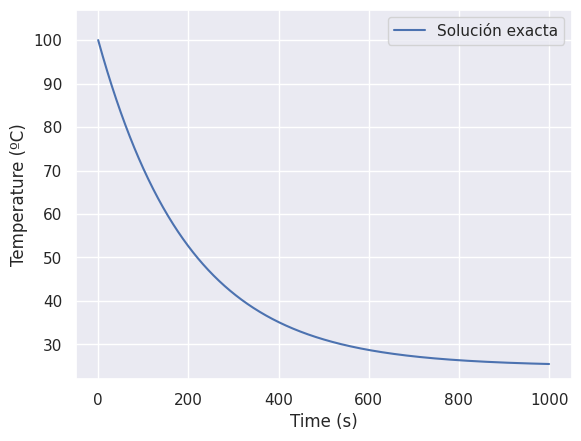

In [7]:
plt.plot(times, temps, label='Solución exacta')
plt.legend()
plt.ylabel('Temperature (ºC)')
plt.xlabel('Time (s)')
plt.ylim(22, 107)

savename = f'{SAVEFOLDER}/plots/exact_solution.png'
plt.savefig(savename, bbox_inches='tight')

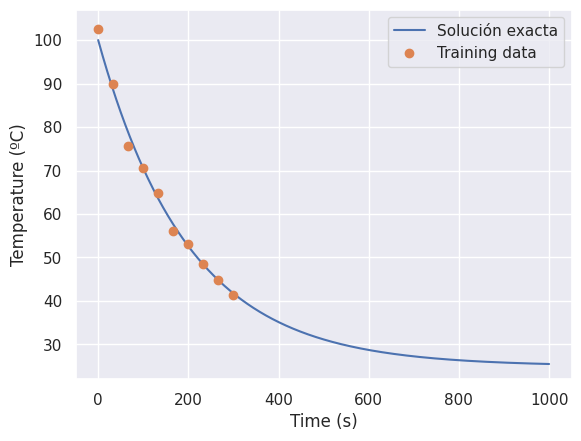

In [8]:
plt.plot(times, temps, label='Solución exacta')
plt.plot(t, T, 'o', label='Training data')
plt.legend()
plt.ylabel('Temperature (ºC)')
plt.xlabel('Time (s)')
plt.ylim(22, 107)

savename = f'{SAVEFOLDER}/plots/exact_solution_and_training.png'
plt.savefig(savename, bbox_inches='tight')

# ML aproximation

## Regular NN

In [9]:
regular_net = Net(1, 1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

regular_losses, regular_func_evals = regular_net.fit(t, T)
y_pred_nn = regular_net.predict(times)

Epoch 0/20000, loss: 4713.87
Epoch 2000/20000, loss: 2510.70
Epoch 4000/20000, loss: 2155.24
Epoch 6000/20000, loss: 758.40
Epoch 8000/20000, loss: 97.10
Epoch 10000/20000, loss: 2.03
Epoch 12000/20000, loss: 0.60
Epoch 14000/20000, loss: 0.34
Epoch 16000/20000, loss: 0.36
Epoch 18000/20000, loss: 0.33


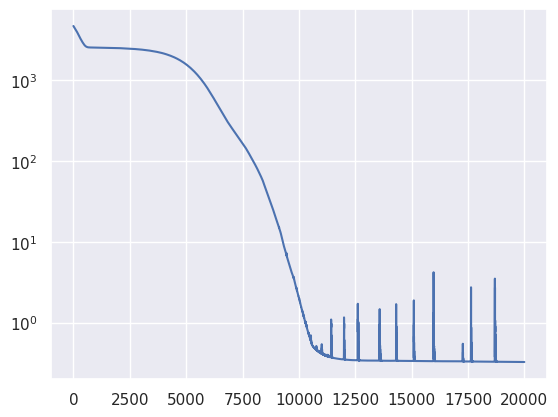

In [10]:
plt.plot(regular_losses)
plt.yscale('log')

savename = f'{SAVEFOLDER}/plots/regular_nn_loss.png'
plt.savefig(savename, bbox_inches='tight')

## Linear regression

In [11]:
model = pipeline.Pipeline([
    # ('poly', preprocessing.PolynomialFeatures(degree=8)),
    ('scaler', preprocessing.StandardScaler()),
    ('model', linear_model.LinearRegression())
    ])

In [12]:
model.fit(t.reshape(-1, 1), T.reshape(-1, 1))
y_pred_lr = model.predict(times.reshape(-1, 1))

## Decission Tree

In [13]:
dt = pipeline.Pipeline([
    # ('poly', preprocessing.PolynomialFeatures(degree=8)),
    ('model', DecisionTreeRegressor(random_state=42))
    ])

In [14]:
dt.fit(t.reshape(-1,1), T.reshape(-1,1))
y_pred_dt = dt.predict(times.reshape(-1, 1))

## Plots

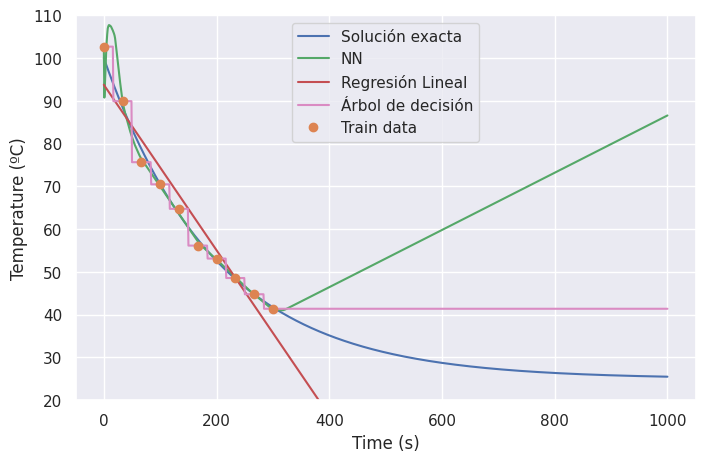

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(times, temps, label='Solución exacta', color='C0')
plt.plot(times, y_pred_nn, label='NN', color='C2')
plt.plot(times, y_pred_lr, label='Regresión Lineal', color='C3')
plt.plot(times, y_pred_dt, label='Árbol de decisión', color='C6')
plt.plot(t, T, 'o', label='Train data', color='C1')
plt.ylim(20, 110)
plt.legend()
plt.ylabel('Temperature (ºC)')
plt.xlabel('Time (s)')

savename = f'{SAVEFOLDER}/plots/all_preds_same_plot.png'
plt.savefig(savename, bbox_inches='tight')

In [16]:
dict_preds = {
    'Regresión Lineal': y_pred_lr,
    'Árbol de decisión': y_pred_dt,
    'NN': y_pred_nn,
}

for label, preds in dict_preds.items():
    savename = f'{SAVEFOLDER}/plots/preds_{label}.png'

    plt.figure(figsize=(8, 5))
    plt.plot(times, temps, label='Solución exacta', color='C0')
    plt.plot(times, preds, label=f'Predicción {label}', color='C2')
    plt.plot(t, T, 'o', label='Train data', color='C1')
    plt.ylim(20, 110)
    plt.legend()
    plt.ylabel('Temperature (ºC)')
    plt.xlabel('Time (s)')

    plt.savefig(savename, bbox_inches='tight')
    plt.close('all')


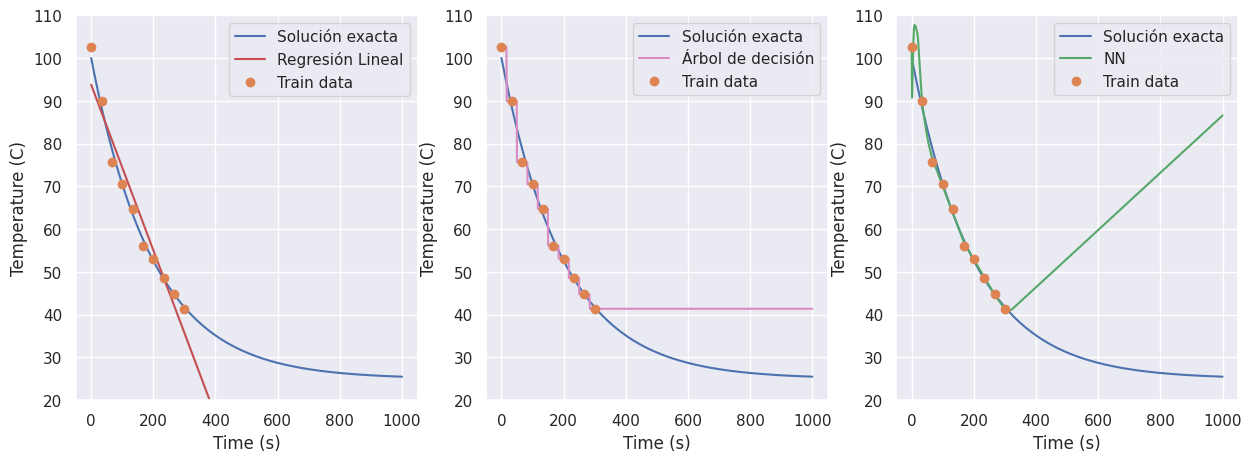

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(times, temps, label='Solución exacta', color='C0')
plt.plot(times, y_pred_lr, label='Regresión Lineal', color='C3')
plt.plot(t, T, 'o', label='Train data', color='C1')
plt.ylim(20, 110)
plt.legend()
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

plt.subplot(1, 3, 2)
plt.plot(times, temps, label='Solución exacta', color='C0')
plt.plot(times, y_pred_dt, label='Árbol de decisión', color='C6')
plt.plot(t, T, 'o', label='Train data', color='C1')
plt.ylim(20, 110)
plt.legend()
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

plt.subplot(1, 3, 3)
plt.plot(times, temps, label='Solución exacta', color='C0')
plt.plot(times, y_pred_nn, label='NN', color='C2')
plt.plot(t, T, 'o', label='Train data', color='C1')
plt.ylim(20, 110)
plt.legend()
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


savename = f'{SAVEFOLDER}/plots/all_preds.png'
plt.savefig(savename, bbox_inches='tight')

# PINN

In [18]:
def physics_loss(model: torch.nn.Module):
    t = torch.linspace(0, 1000, steps=1000).view(-1,1).requires_grad_(True).to(DEVICE)
    T = model(t)
    dT = torch.autograd.grad(T, t, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    pde = R*(Tenv - T) - dT

    return torch.mean(pde**2)

In [19]:
pinn_net = Net(1, 1, loss2=physics_loss, epochs=20000, loss2_weight=1, lr=1e-5).to(DEVICE)

pinn_losses, pinn_func_evals = pinn_net.fit(t, T)
pinn_preds = pinn_net.predict(times)

Epoch 0/20000, loss: 4622.81
Epoch 2000/20000, loss: 2497.40
Epoch 4000/20000, loss: 1941.36
Epoch 6000/20000, loss: 233.77
Epoch 8000/20000, loss: 2.68
Epoch 10000/20000, loss: 1.23
Epoch 12000/20000, loss: 0.57
Epoch 14000/20000, loss: 0.46
Epoch 16000/20000, loss: 0.40
Epoch 18000/20000, loss: 0.37


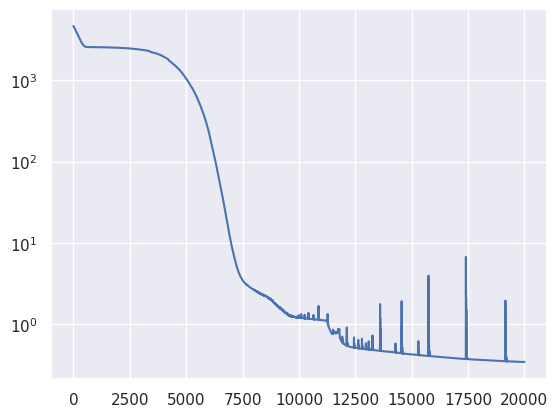

In [20]:
plt.plot(pinn_losses)
plt.yscale('log')

savename = f'{SAVEFOLDER}/plots/pinn_loss.png'
plt.savefig(savename, bbox_inches='tight')

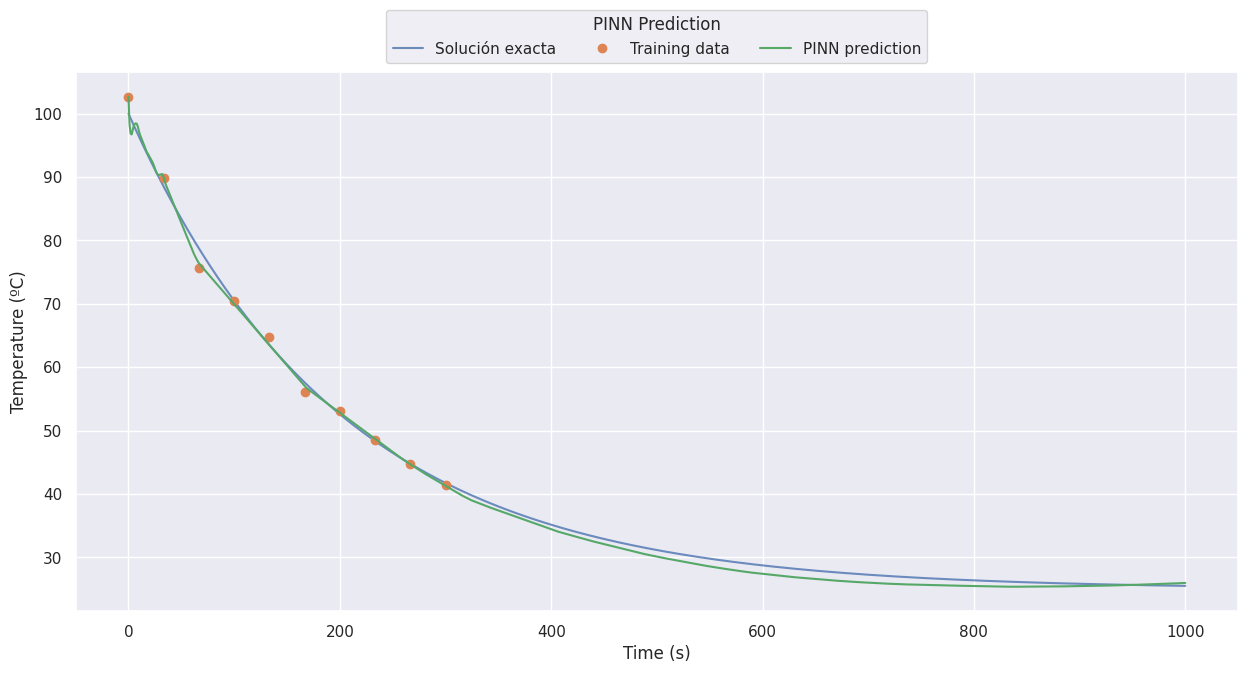

In [21]:
plt.figure(figsize=(15, 7))
generate_plot(model_ts=pinn_preds, legend_plot_name='PINN prediction', step_id=0)
plt.legend(title=f'PINN Prediction', loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3)

savename = f'{SAVEFOLDER}/plots/pinn_prediction.png'
plt.savefig(savename, bbox_inches='tight')

# Parameter discovery

In [22]:
def physics_loss_discovery(model: torch.nn.Module):
    t = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    T = model(t)
    dT = torch.autograd.grad(T, t, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    pde = model.r * (Tenv - T) - dT

    return torch.mean(pde**2)

In [23]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=25000, lr=5e-6).to(DEVICE)

disc_pinn_losses, disc_pinn_func_evals = netdisc.fit(t, T)
disc_pinn_preds = netdisc.predict(times)
print('Discovered R param:', netdisc.r)

Epoch 0/25000, loss: 4775.81
Epoch 2500/25000, loss: 2544.24
Epoch 5000/25000, loss: 2489.79
Epoch 7500/25000, loss: 2309.20
Epoch 10000/25000, loss: 1610.50
Epoch 12500/25000, loss: 492.22
Epoch 15000/25000, loss: 35.48
Epoch 17500/25000, loss: 1.48
Epoch 20000/25000, loss: 0.49
Epoch 22500/25000, loss: 0.44
Discovered R param: Parameter containing:
tensor([0.0055], requires_grad=True)


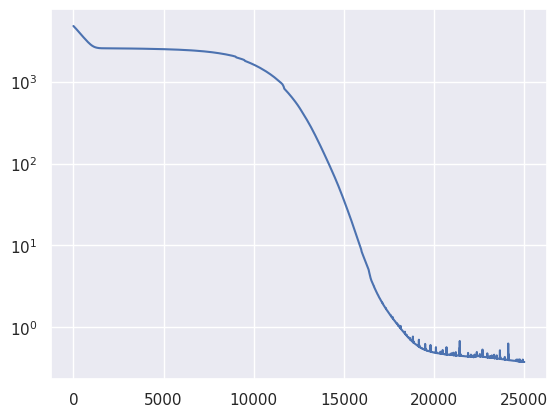

In [24]:
plt.plot(disc_pinn_losses)
plt.yscale('log')

savename = f'{SAVEFOLDER}/plots/pinn_loss_discovery.png'
plt.savefig(savename, bbox_inches='tight')

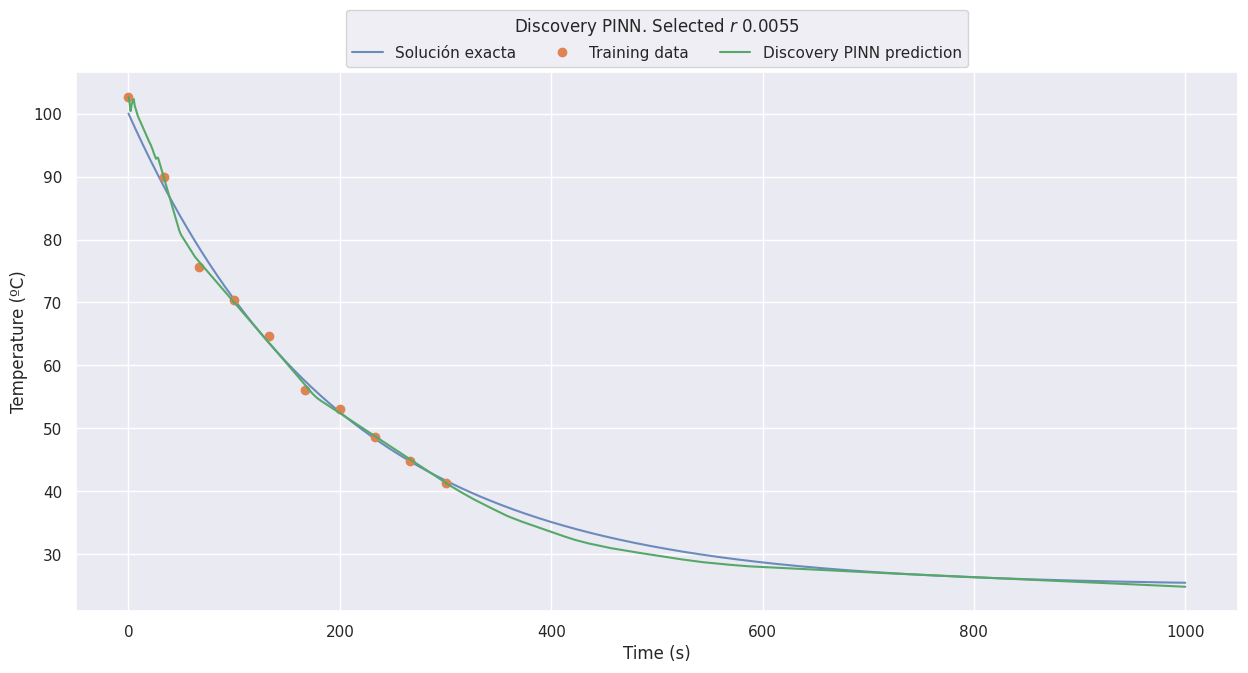

In [25]:
plt.figure(figsize=(15, 7))
generate_plot(model_ts=disc_pinn_preds, legend_plot_name='Discovery PINN prediction', step_id=0)
plt.legend(title=f'Discovery PINN. Selected $r$ {netdisc.r.item():.4f}', loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3)

savename = f'{SAVEFOLDER}/plots/pinn_discovery_prediction.png'
plt.savefig(savename, bbox_inches='tight')

# Plots

In [26]:
def generate_nn_evolution_plots(model_evals, output_folder, legend_plot_name, n_plots=500):
    plots_savepath = f'{SAVEFOLDER}/{output_folder}/'
    selected_plots = np.linspace(0, len(model_evals) - 1, num=n_plots, dtype=int)
    for plot_id in selected_plots:
        savename = f'{plots_savepath}/img_{plot_id:0>5}.png'
        plt.figure(figsize=(8, 5))
        generate_plot(model_evals[plot_id], legend_plot_name, step_id=plot_id)
        plt.savefig(savename, bbox_inches='tight')
        plt.close('all')

In [27]:
def generate_regular_vs_pinn_plots(regular_evals, pinn_evals, output_folder, n_plots=500):
    plots_savepath = f'{SAVEFOLDER}/{output_folder}/'
    selected_plots = np.linspace(0, len(regular_evals) - 1, num=n_plots, dtype=int)
    for plot_id in selected_plots:
        savename = f'{plots_savepath}/img_{plot_id:0>5}.png'

        min_y = np.min([22, np.min(regular_evals[plot_id]) - 5, np.min(pinn_evals[plot_id]) - 5])
        max_y = np.max([107, np.max(regular_evals[plot_id]) + 5, np.max(pinn_evals[plot_id]) + 5])

        plt.figure(figsize=(17, 7))

        plt.subplot(1, 2, 1)
        generate_plot(regular_evals[plot_id], legend_plot_name='NN prediction', step_id=plot_id)
        plt.legend(title=f'NN Training step {plot_id+1: >5}', loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3)
        plt.ylim(min_y, max_y)

        plt.subplot(1, 2, 2)
        generate_plot(pinn_evals[plot_id], legend_plot_name='PINN prediction', step_id=plot_id)
        plt.legend(title=f'PINN Training step {plot_id+1: >5}', loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3)
        plt.ylim(min_y, max_y)

        plt.savefig(savename, bbox_inches='tight')
        plt.close('all')

In [28]:
n_plots = 300
generate_nn_evolution_plots(model_evals=regular_func_evals, output_folder='regular_nn_results', legend_plot_name='NN prediction', n_plots=n_plots)
generate_nn_evolution_plots(model_evals=pinn_func_evals, output_folder='pinn_results', legend_plot_name='PINN prediction', n_plots=n_plots)
generate_nn_evolution_plots(model_evals=disc_pinn_func_evals, output_folder='pinn_disc_results', legend_plot_name='Discovery PINN prediction', n_plots=n_plots)
generate_regular_vs_pinn_plots(regular_evals=regular_func_evals, pinn_evals=pinn_func_evals, output_folder='regular_vs_pinn', n_plots=n_plots)

## Video generation

In [29]:
def generate_evolution_video(target_folder, total_video_duration=30):
    image_folder = f'{SAVEFOLDER}/{target_folder}/'
    video_name = f'{SAVEFOLDER}/{target_folder}.avi'

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    n_frames = len(images)
    teorical_fps = n_frames/total_video_duration

    video = cv2.VideoWriter(video_name, 0, fps=teorical_fps, frameSize=(width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

In [30]:
generate_evolution_video(target_folder='regular_nn_results', total_video_duration=45)
generate_evolution_video(target_folder='pinn_results', total_video_duration=45)
generate_evolution_video(target_folder='pinn_disc_results', total_video_duration=45)
generate_evolution_video(target_folder='regular_vs_pinn', total_video_duration=45)